In [3]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu MHz		: 2200.224
cpu cores	: 1
# RAM
MemTotal:       13290452 kB
# GPU

# OS
Linux 2775aa485437 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


## Title text



In [4]:
!pip install --upgrade keras-hub

# Default title text
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras

from keras import losses, optimizers

import keras_hub
from keras_hub.models import BertTextClassifier

import os
from scipy.stats import spearmanr
from math import floor, ceil
#from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
2.18.0


## Load and preprocess the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Load reddit_jokes dataset

In [6]:
!git clone https://github.com/taivop/joke-dataset.git /content/drive/MyDrive/Colab/content/reddit_jokes
df = pd.read_json('/content/drive/MyDrive/Colab/content/reddit_jokes/reddit_jokes.json')
df["input_text"] = df["title"] + " " + df["body"] #combining the two text fields

fatal: destination path '/content/drive/MyDrive/Colab/content/reddit_jokes' already exists and is not an empty directory.


### Load dataset from ColBERT paper

In [7]:
!git clone https://github.com/Moradnejad/ColBERT-Using-BERT-Sentence-Embedding-for-Humor-Detection.git /content/drive/MyDrive/Colab/content/colBERT


# Make sure it exists
!ls /content/drive/MyDrive/Colab/content/colBERT

# Where it is
file_path = '/content/drive/MyDrive/Colab/content/colBERT/Data/train.csv'

df_colbert = pd.read_csv(file_path) #load dataset

# Convert the 'humor' column to binary labels (False -> 0, True -> 1)
df_colbert['label'] = df_colbert['humor'].map({False: 0, True: 1})

#Take out unnessasary columuns
df_colbert['input_text'] = df_colbert['text']
df_colbert=df_colbert[['input_text','label']]


# Our data
print(df_colbert.head())

fatal: destination path '/content/drive/MyDrive/Colab/content/colBERT' already exists and is not an empty directory.
colbert-train-model-notebook.ipynb  colbert-using-pretrained-model.ipynb  Data	LICENSE  README.md
                                          input_text  label
0  Joe biden rules out 2020 bid: 'guys, i'm not r...      0
1  Watch: darvish gave hitter whiplash with slow ...      0
2  What do you call a turtle without its shell? d...      1
3      5 reasons the 2016 election feels so personal      0
4  Pasco police shot mexican migrant from behind,...      0


In [8]:
print(np.max(df['score']))

48526


### Assign labels based on scores; separate long and short jokes

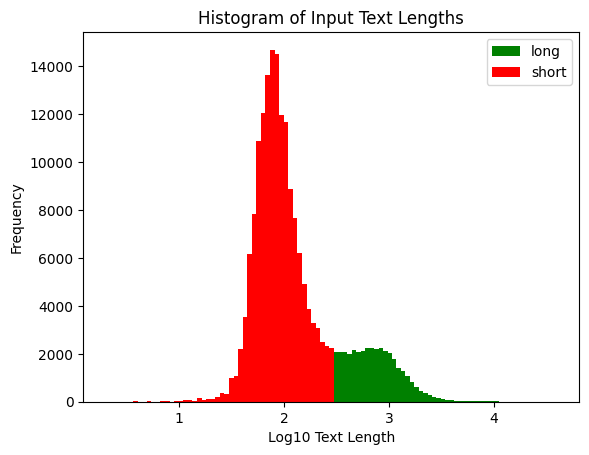

In [9]:
#set cut-off score for "funny" and "unfunny" classes
cut_off_score=10
def map_score_to_label(score):
    if score < cut_off_score:
      return 0
    else:
      return 1

df['label'] = df['score'].apply(map_score_to_label)


threshold=50
df['score_capped'] = df['score'].clip(upper=threshold)

cut_off_length = 300 # Adjust this value as needed

df_long = df[df['input_text'].apply(len) > cut_off_length]
df_short = df[df['input_text'].apply(len) <= cut_off_length]


# Calculate the length of strings in the 'input_text' column and cap the values
L_long = df_long['input_text'].apply(len)
L_short= df_short['input_text'].apply(len)



# Plot histogram of log10 text lengths

plt.hist(np.log10(L_long), bins=50, color='green', label='long')
plt.hist(np.log10(L_short), bins=50, color='red', label='short')
plt.title(f'Histogram of Input Text Lengths')
plt.xlabel('Log10 Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

df_long = df[df['input_text'].apply(len) > cut_off_length]
df_short = df[df['input_text'].apply(len) <= cut_off_length]


### Visualize score distributions

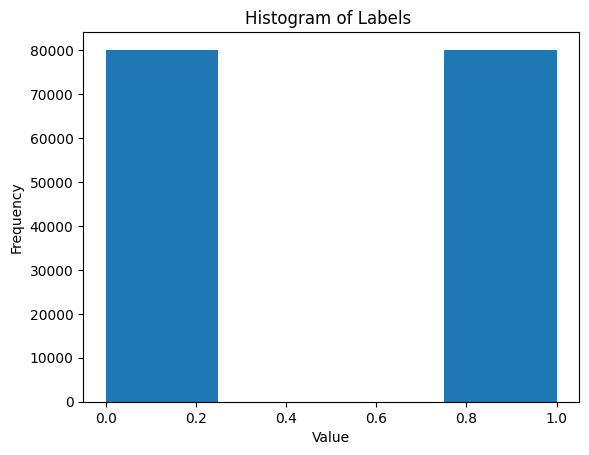

In [10]:
plt.hist(df_colbert['label'], bins=4)
plt.xlabel(f'Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Labels ')
plt.show()

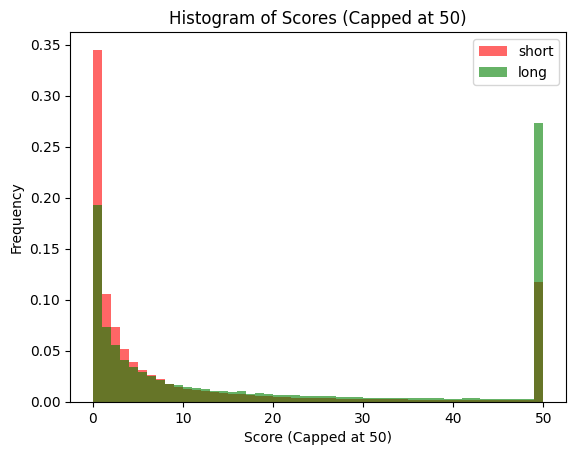

Median short joke score: 2.0
Median long joke score: 9.0


In [11]:

plt.hist(df_short['score_capped'], bins=threshold, density=True, color='red', label='short', alpha=0.6)
plt.hist(df_long['score_capped'], bins=threshold, density=True, color='green', label='long', alpha=0.6)
plt.xlabel(f'Score (Capped at {threshold})')
plt.ylabel('Frequency')
plt.title(f'Histogram of Scores (Capped at {threshold})')
plt.legend()
plt.show()
print("Median short joke score:", np.median(df_short['score']))
print("Median long joke score:", np.median(df_long['score']))



### Split the dataset for training/testing

In [12]:
df_train, df_test = train_test_split(df, test_size=.4, random_state=500, stratify=df['label'])
df_train_long, df_test_long = train_test_split(df_long, test_size=.4, random_state=500, stratify=df_long['label'])
df_train_short, df_test_short = train_test_split(df_short, test_size=.4, random_state=500, stratify=df_short['label'])
df_train_colbert, df_test_colbert = train_test_split(df_colbert, test_size=.4, random_state=500, stratify=df_colbert['label'])

#Test size is 0.4 due to size of datsets (small)

## Modeling



### Initilize and train the model

In [1]:
# initialize pretrained classifier from Keras
# model from https://keras.io/keras_hub/api/models/
model_name='bert_tiny_en_uncased'
classifier = keras_hub.models.TextClassifier.from_preset(model_name, num_classes=2)


# Choose the training set
# train_subset=df_train[:20000]
# train_subset=df_train_long
train_subset=df_train_colbert[:10000]

# Extract features and labels
features =train_subset['input_text'].tolist() # List of text features
labels = train_subset['label'].tolist() # List of labels



classifier.fit(x=features, y=labels, batch_size=10)

# To save the  model
#classifier.save('/content/drive/MyDrive/Colab/content/colbert_10K.keras')







NameError: name 'keras_hub' is not defined

### Apply model to the test dataset

In [13]:
# load our trained models

#classifier= tf.keras.models.load_model('/content/drive/MyDrive/Colab/content/full_score10_20K.keras')
#test_subset=df_test[:15000]

classifier= tf.keras.models.load_model('/content/drive/MyDrive/Colab/content/long_score10_22K.keras')
test_subset=df_test_long

#classifier= tf.keras.models.load_model('/content/drive/MyDrive/Colab/content/colbert_10K.keras')
#test_subset=df_test_colbert[:10000]

x_test = test_subset['input_text'].tolist()  # List of text features
y_test = test_subset['label'].tolist()



predictions_test = classifier.predict(x=x_test, batch_size=10)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1466/1466 ━━━━━━━━━━━━━━━━━━━━ 553s 374ms/step


### Visualize results

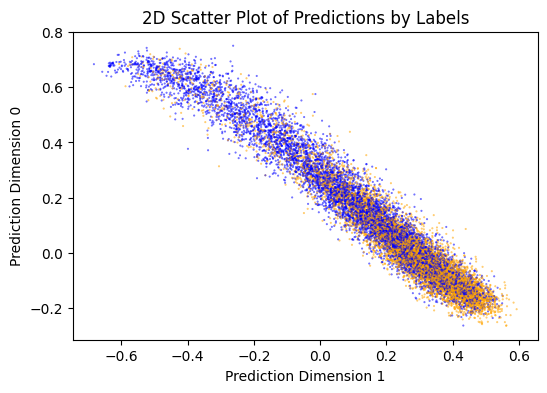

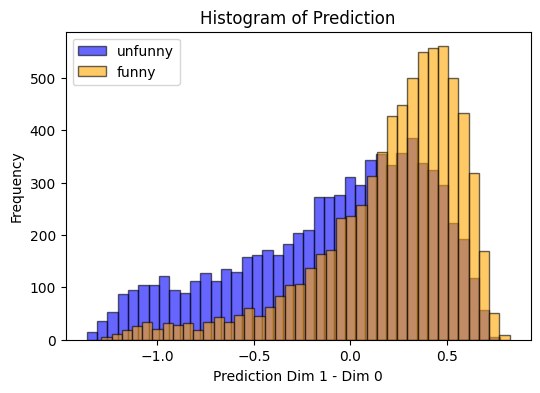

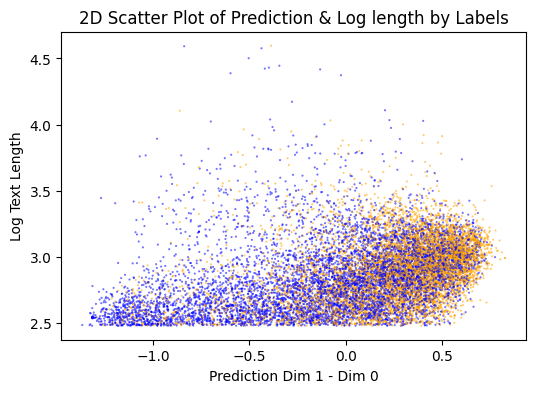

In [14]:
labels_array = np.array(y_test)

predictions_label_0 = predictions_test[labels_array == 0]
predictions_label_1 = predictions_test[labels_array == 1]

color_array = test_subset['label'].apply(lambda x: 'orange' if x == 1 else 'blue')

plt.figure(figsize=(6, 4))


plt.scatter(predictions_test[:, 1], predictions_test[:, 0], color=color_array,marker='.',s=1, alpha=0.6)

# Add labels, legend, and title
plt.title('2D Scatter Plot of Predictions by Labels')
plt.xlabel('Prediction Dimension 1')
plt.ylabel('Prediction Dimension 0')
#plt.legend()


# Show the plot
plt.show()

plt.figure(figsize=(6, 4))

plt.hist(predictions_label_0[:, 1]-predictions_label_0[:, 0], bins=40, alpha=0.6, color='blue',edgecolor='k', label='unfunny')
plt.hist(predictions_label_1[:, 1]-predictions_label_1[:, 0], bins=40, alpha=0.6, color='orange', edgecolor='k', label='funny')

plt.title('Histogram of Prediction')
plt.xlabel('Prediction Dim 1 - Dim 0')
plt.ylabel('Frequency')
plt.legend()
plt.show()


log_length= np.log10(test_subset['input_text'].apply(len))
plt.figure(figsize=(6, 4))


plt.scatter(predictions_test[:, 1]-predictions_test[:, 0],log_length, color=color_array,marker='.',s=1, alpha=0.6)

# Add labels, legend, and title
plt.title('2D Scatter Plot of Prediction & Log length by Labels')
plt.xlabel('Prediction Dim 1 - Dim 0')
plt.ylabel('Log Text Length')
#plt.legend()


# Show the plot
plt.show()







### Evaluate the model

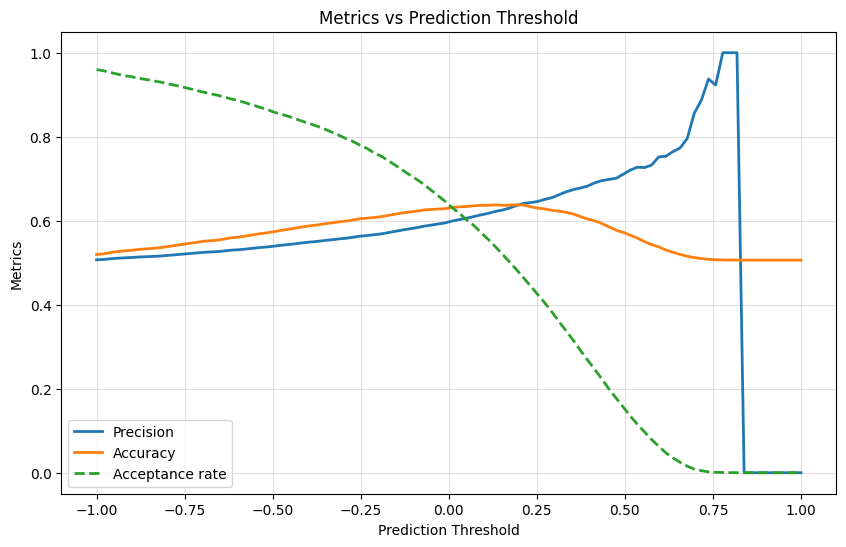

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

true_labels = np.array(test_subset['label'])

# generate a range of thresholds
thresholds = np.linspace(-1, 1, 100)
precision_values = []
accuracy_values = []
fraction_filtered = []

# calculate precision, accuracy, and fraction filtered for each threshold
for prediction_threshold in thresholds:
    model_labels = (predictions_test[:, 1] - predictions_test[:, 0] > prediction_threshold).astype(int)
    precision = precision_score(true_labels, model_labels, zero_division=0)
    accuracy = accuracy_score(true_labels, model_labels)
    filtered_fraction = model_labels.sum() / len(true_labels)  # Fraction of dataset predicted as positive
    precision_values.append(precision)
    accuracy_values.append(accuracy)
    fraction_filtered.append(filtered_fraction)

# plot precision, accuracy, and fraction filtered vs. prediction threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, label="Precision", linewidth=2)
plt.plot(thresholds, accuracy_values, label="Accuracy", linewidth=2)
plt.plot(thresholds, fraction_filtered, label="Acceptance rate", linewidth=2, linestyle='--')
plt.xlabel("Prediction Threshold")
plt.ylabel("Metrics")
plt.title("Metrics vs Prediction Threshold")
plt.grid(alpha=0.4)
plt.legend()
plt.show()


In [16]:


prediction_threshold=0.3
model_labels = (predictions_test[:, 1] - predictions_test[:, 0] > prediction_threshold).astype(int)
true_labels = np.array(test_subset['label'])

conf_matrix = confusion_matrix(true_labels, model_labels)
precision = precision_score(true_labels, model_labels)
accuracy= accuracy_score(true_labels, model_labels)
#f1 = f1_score(true_labels, model_labels)
# display confusion matrix and precision
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["True 0", "True 1"],
    columns=["Predicted 0", "Predicted 1"]
)
display(conf_matrix_df)
print('Total:', len(true_labels))
print("Precision:", precision)
print("Accuracy:", accuracy)




,Predicted 0,Predicted 1
True 0,5549,1872
True 1,3626,3613


Total: 14660
Precision: 0.6587055606198724
Accuracy: 0.6249658935879946


### Generate curated dataset

Full dataset median score: 3.0
Median long joke score: 9.0
Median curated score: 25.0


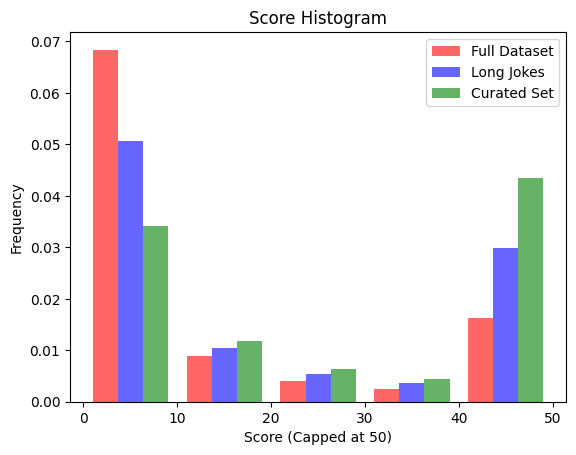

In [17]:
import seaborn as sns

test_curated=test_subset[predictions_test[:,1]-predictions_test[:,0]>prediction_threshold]

#print("Cureated list length:", len(test_curated))
print("Full dataset median score:", np.median(df['score']))
print("Median long joke score:", np.median(df_long['score']))
print("Median curated score:", np.median(test_curated['score']))
# plt.hist(test_curated['score_capped'], bins=threshold, facecolor='orange', edgecolor='red', alpha=1,density=True, label='curated set')
# plt.hist(df_long['score_capped'], bins=threshold, facecolor='blue', edgecolor='purple', alpha=0.5, density=True,label='long jokes')
# plt.hist(df['score_capped'], bins=threshold, facecolor='green', edgecolor = 'k', alpha=0.3, density=True,label='full dataset')


plt.hist([df['score_capped'], df_long['score_capped'],test_curated['score_capped']], color=['r','b','g'],
         label = ['Full Dataset', 'Long Jokes', 'Curated Set'],
         bins = 5, alpha=0.6,  density=True)


plt.xlabel(f'Score (Capped at {threshold})')
plt.ylabel('Frequency')
plt.title(f'Score Histogram')
plt.legend()
plt.show()
pd.set_option('display.max_colwidth', None)
